# Classifying prompt vs. fake photons from $t\bar{t}$, $t\bar{t}+\gamma$ events

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [3]:
# import tensorflow as tf
from keras.models import save_model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [4]:
import pickle
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

make_keras_picklable()

## Load data

In [5]:
from coffea import hist, util
from coffea.util import load

In [6]:
outputMC = load('outputMC.coffea')
outputData = load('outputData.coffea')

In [7]:
outputMC_high = load('outputMC_high.coffea')
outputMC_low  = load('outputMC_low.coffea')

## Plot Features

In [8]:
np.warnings.filterwarnings('ignore')

In [9]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1}

data_legopts = {'labels':[None,'prompt electron (13)','prompt photon (1)','fake photon (0)','data, $L = 5780~{pb}^{-1}$'],'loc':'best'}

rat_denom_opts = {}

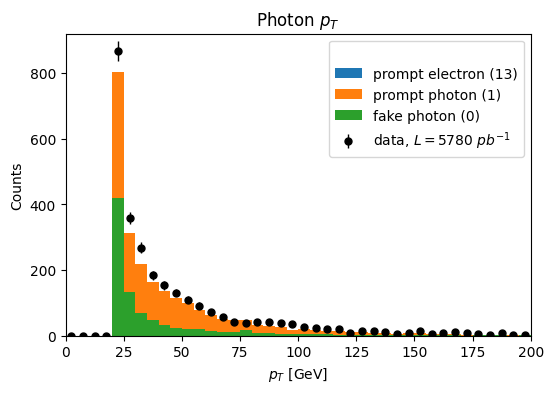

In [10]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_pt_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_pt_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,920); plt.title('Photon $p_T$'); plt.show()

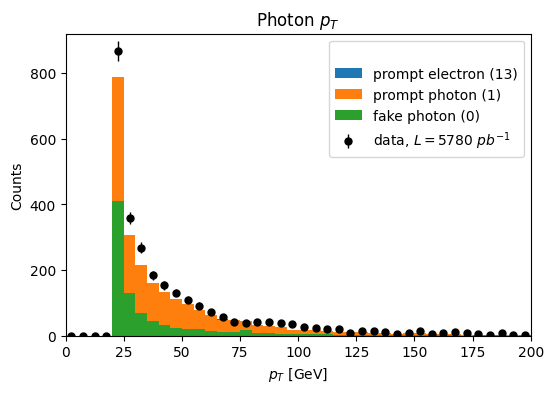

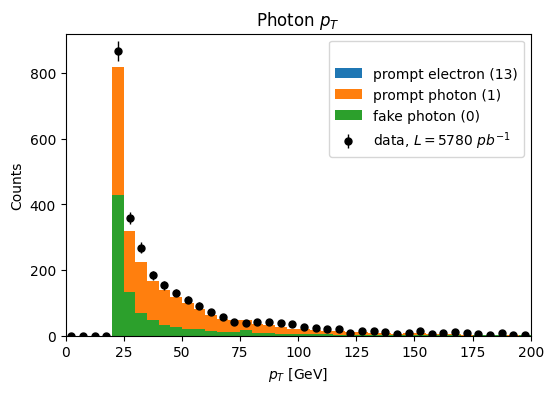

In [11]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC_low['photon_pt_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_pt_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,920); plt.title('Photon $p_T$'); plt.show()

plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC_high['photon_pt_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_pt_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,920); plt.title('Photon $p_T$'); plt.show()

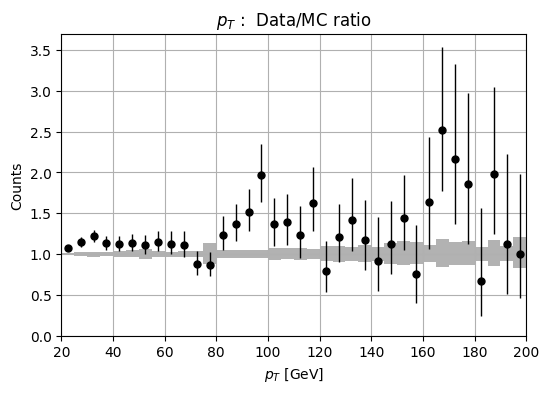

In [12]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_pt_hist'],outputMC['photon_pt_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('$p_T$ :  Data/MC ratio'); plt.grid()
plt.show()

In [13]:
#####  ------- from  hist.plotratio ---------  ####

In [14]:
from scipy.stats import norm, chi2
_coverage1sd = norm.cdf(1) - norm.cdf(-1)
def poisson_interval(sumw, sumw2, coverage=_coverage1sd):
    scale = np.empty_like(sumw)
    scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]
    if np.sum(sumw == 0) > 0:
        missing = np.where(sumw == 0)
        available = np.nonzero(sumw)
        if len(available[0]) == 0:
            warnings.warn(
                "All sumw are zero!  Cannot compute meaningful error bars",
                RuntimeWarning,
            )
            return np.vstack([sumw, sumw])
        nearest = sum(
            [np.subtract.outer(d, d0) ** 2 for d, d0 in zip(available, missing)]
        ).argmin(axis=0)
        argnearest = tuple(dim[nearest] for dim in available)
        scale[missing] = scale[argnearest]
    counts = sumw / scale
    lo = scale * chi2.ppf((1 - coverage) / 2, 2 * counts) / 2.0
    hi = scale * chi2.ppf((1 + coverage) / 2, 2 * (counts + 1)) / 2.0
    interval = np.array([lo, hi])
    interval[interval == np.nan] = 0.0  # chi2.ppf produces nan for counts=0
    return interval

**Poisson confidence interval:**

Lower confidence limit: $\frac{1}{2} \chi^{2}_{2y,~\alpha/2}$

Upper confidence limit: $\frac{1}{2} \chi^{2}_{2(y+1),~(1-\alpha)/2}$

Where:
* $y$ is the number of events in a given bin.
* $\alpha$ is the significance level (e.g. if you want 95% confidence, then $\alpha = 1 - 0.95 = 0.05$). In our case, we have $\alpha$ defined by the cumulative distribution function:
    * `norm.cdf(x)` $= \int_{-\infty}^{x}{ \frac{1}{\sqrt{2\pi}}e^{-t^2 /2}~dt}$, where $f(t) = \frac{1}{\sqrt{2\pi}}e^{-t^2 /2}$ is the normal distribution function.
    * So, $\alpha = 1 -$ `norm.cdf(1) - norm.cdf(-1)` $= 1 - 0.68 = 0.32$.
* $\chi^{2}_{v,a}$ is the chi-squared critical value (inverse `cdf`) for degrees of freedom $v$ and significance level $a$.

In [15]:
1 - (norm.cdf(1) - norm.cdf(-1))

0.31731050786291415

In [16]:
# x (pT) axis:
centers = outputMC['photon_pt_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_pt_hist'].sum("dataset").sum("flav").axes()[0].edges()
print(centers)
print(edges)


# y (ratio) axis:
MC_pt, MC_err2 = outputMC['photon_pt_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
Dat_pt, Dat_err2 = outputData['photon_pt_hist'].values(sumw2=True)[()]

rat_pt = Dat_pt/MC_pt
print("\nratio value:")
print(rat_pt)


# ratio uncertainty (error bars):
rat_err = np.abs(poisson_interval(rat_pt, Dat_err2 / MC_pt**2) - rat_pt)
print("\nratio error (lower bound, upper bound):")
print(rat_err)

# denominator uncertainty (gray error band):
unity = np.ones_like(MC_pt)
denom_unc = poisson_interval(unity, MC_err2 / MC_pt**2)
print("\ndenominator uncertainty (lower bound, upper bound):")
print(denom_unc)

[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5 152.5 157.5 162.5 167.5 172.5 177.5
 182.5 187.5 192.5 197.5]
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200.]

ratio value:
[       nan        nan        nan        nan 1.07803208 1.14345936
 1.21808228 1.13185817 1.12619022 1.14030914 1.11278699 1.15191056
 1.12852206 1.11034793 0.8795939  0.86100131 1.23864589 1.3684695
 1.51895394 1.96299782 1.36377305 1.39018575 1.23739605 1.63036364
 0.79298666 1.20859656 1.421059   1.16831374 0.91343398 1.12922701
 1.44757854 0.75695007 1.63301823 2.52115993 2.16009997 1.86130898
 0.67207611 1.9811831  1.12712916 1.00082469]

ratio error (lower bound, upper bound):
[[       nan        nan        nan        na

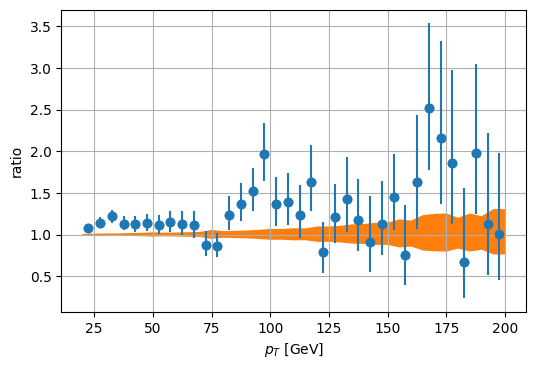

In [17]:
### ---- systematic uncertainty: integrated luminosity ---- ###

hi_MC_pt, hi_MC_err2 = outputMC_high['photon_pt_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC_pt, lo_MC_err2 = outputMC_low['photon_pt_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

hi_rat_pt = Dat_pt/hi_MC_pt
lo_rat_pt = Dat_pt/lo_MC_pt

# denom error band:
sig = (hi_MC_pt - lo_MC_pt)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC_pt**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat_pt)
plt.errorbar(centers, rat_pt, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1], denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('$p_T$ [GeV]'); plt.ylabel('ratio')
plt.show()

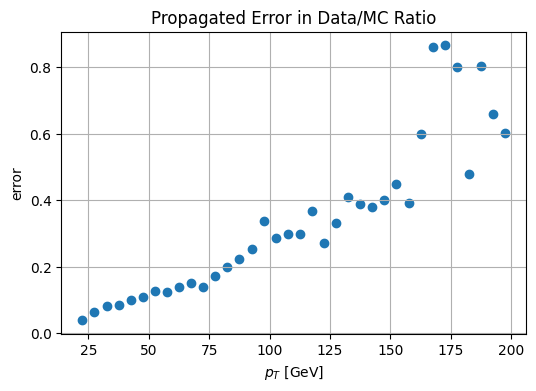

In [18]:
### ---- statistical uncertainties ---- ###
# propagate error from taking a ratio Data/MC
stat_err = abs(rat_pt)*np.sqrt((Dat_err2/Dat_pt**2) + (MC_err2/MC_pt**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('$p_T$ [GeV]'); plt.ylabel('error')
plt.show()

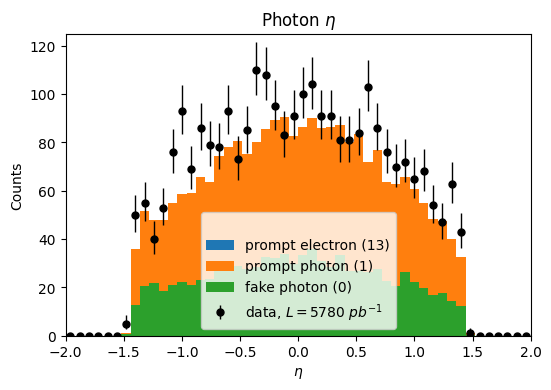

In [19]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_eta_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_eta_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,125); plt.title('Photon $\eta$'); plt.show()

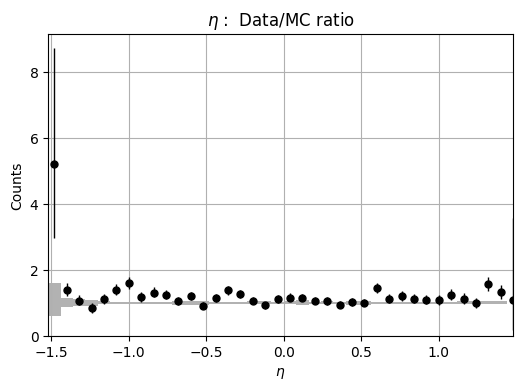

In [20]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_eta_hist'],outputMC['photon_eta_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('$\eta$ :  Data/MC ratio'); plt.grid()
plt.show()

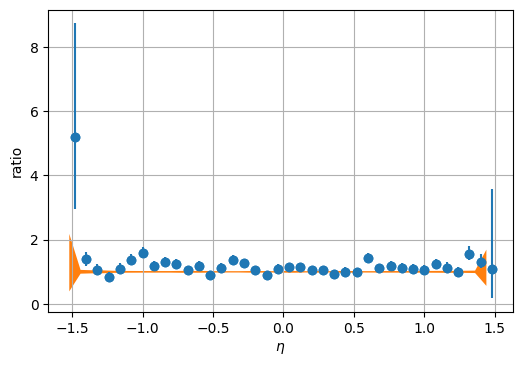

In [21]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_eta_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_eta_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_eta_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_eta_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_eta_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_eta_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('$\eta$'); plt.ylabel('ratio')
plt.show()

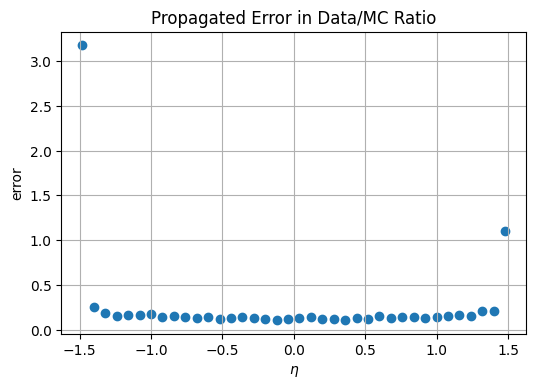

In [22]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('$\eta$'); plt.ylabel('error')
plt.show()

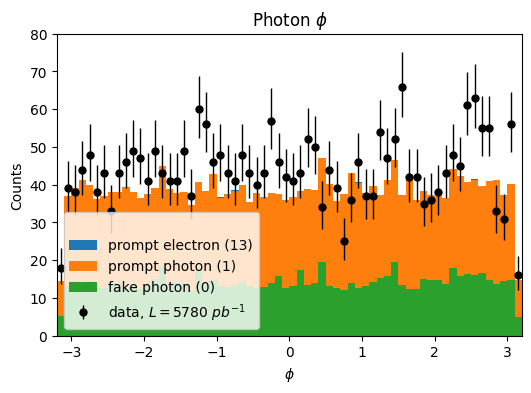

In [23]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_phi_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_phi_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,80); plt.title('Photon $\phi$'); plt.show()

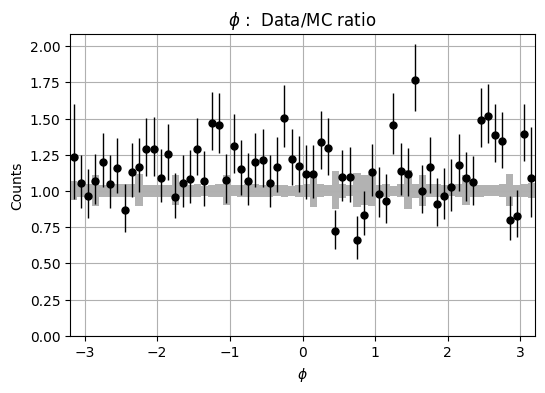

In [24]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_phi_hist'],outputMC['photon_phi_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('$\phi$ :  Data/MC ratio'); plt.grid()
plt.show()

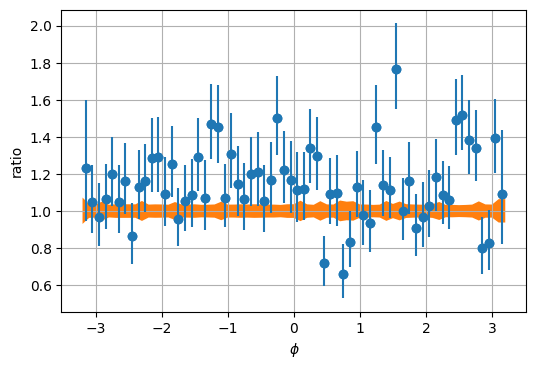

In [25]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_phi_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_phi_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_phi_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_phi_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_phi_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_phi_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('$\phi$'); plt.ylabel('ratio')
plt.show()

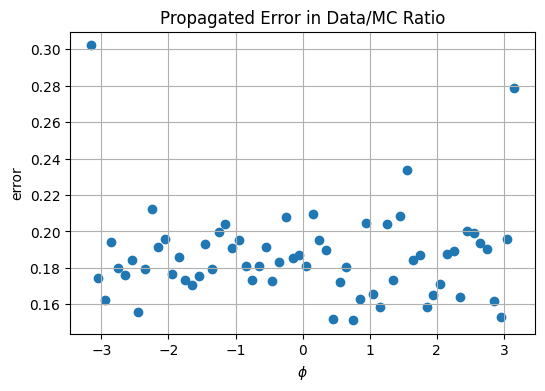

In [26]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('$\phi$'); plt.ylabel('error')
plt.show()

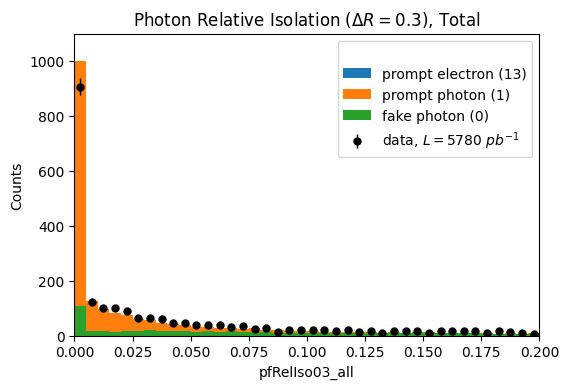

In [27]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_all_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_reliso_all_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,1100); plt.title('Photon Relative Isolation ($\Delta R = 0.3$), Total'); plt.show()

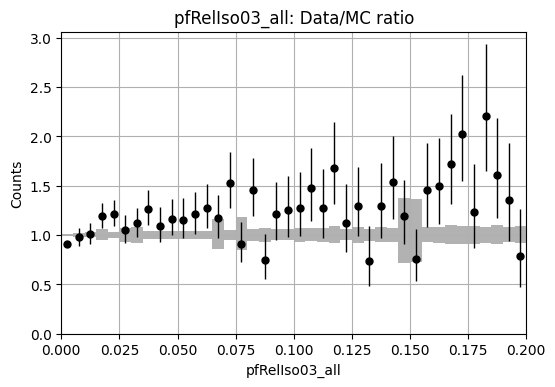

In [28]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_reliso_all_hist'],outputMC['photon_reliso_all_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('pfRelIso03_all: Data/MC ratio'); plt.grid()
plt.show()

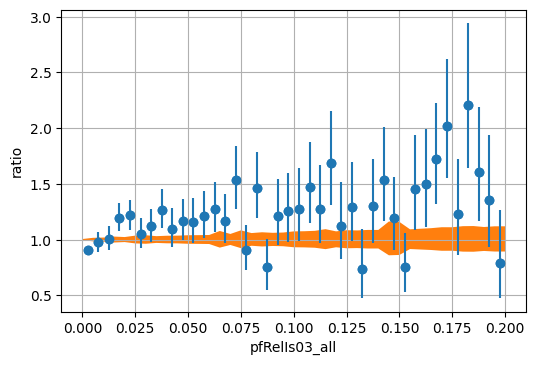

In [29]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_reliso_all_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_reliso_all_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_reliso_all_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_reliso_all_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_reliso_all_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_reliso_all_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('pfRelIs03_all'); plt.ylabel('ratio')
plt.show()

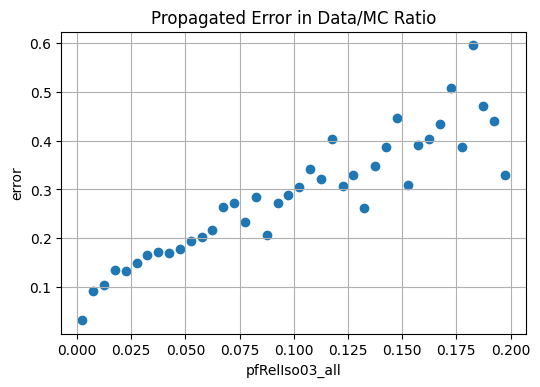

In [30]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('pfRelIso03_all'); plt.ylabel('error')
plt.show()

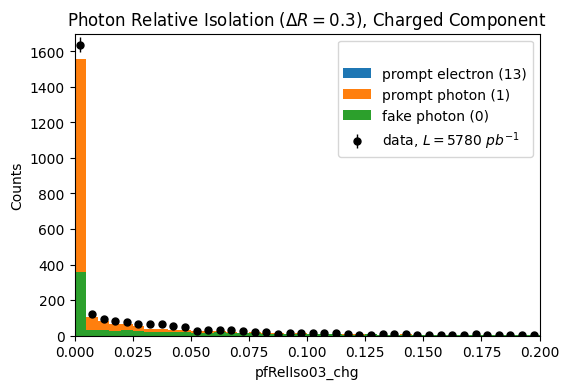

In [31]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_chg_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_reliso_chg_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,1700); plt.title('Photon Relative Isolation ($\Delta R = 0.3$), Charged Component'); plt.show()

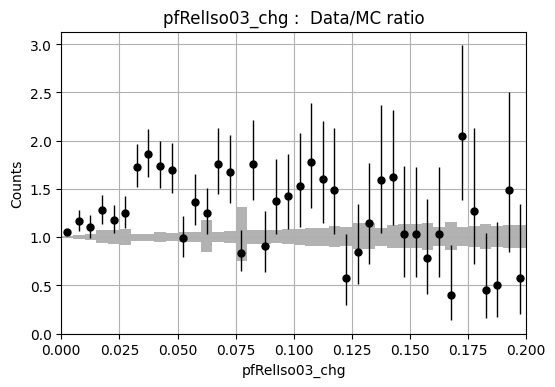

In [32]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_reliso_chg_hist'],outputMC['photon_reliso_chg_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('pfRelIso03_chg :  Data/MC ratio'); plt.grid()
plt.show()

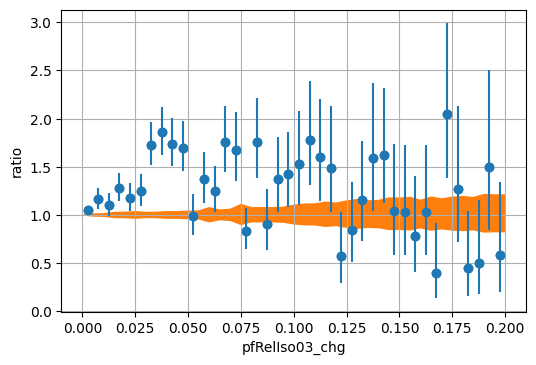

In [33]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_reliso_chg_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_reliso_chg_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_reliso_chg_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_reliso_chg_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_reliso_chg_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_reliso_chg_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('pfRelIso03_chg'); plt.ylabel('ratio')
plt.show()

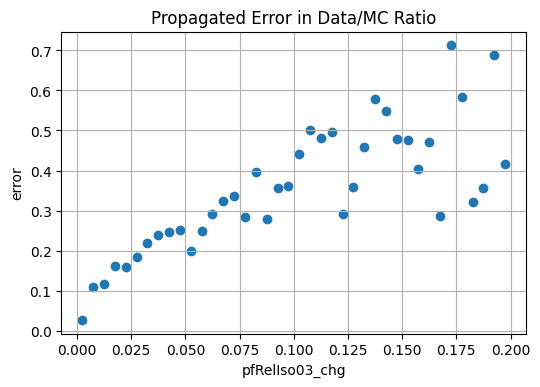

In [34]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('pfRelIso03_chg'); plt.ylabel('error')
plt.show()

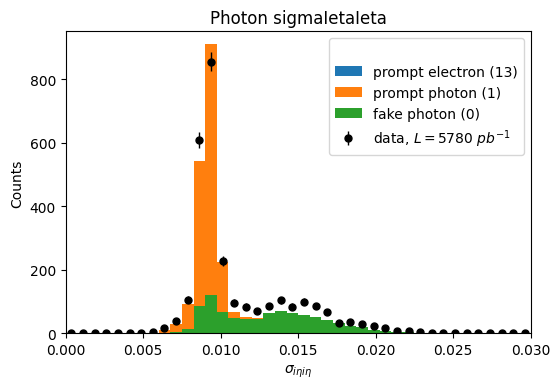

In [35]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_sieie_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts,)
hist.plot1d(outputData['photon_sieie_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,950); plt.title('Photon sigmaIetaIeta'); plt.show()

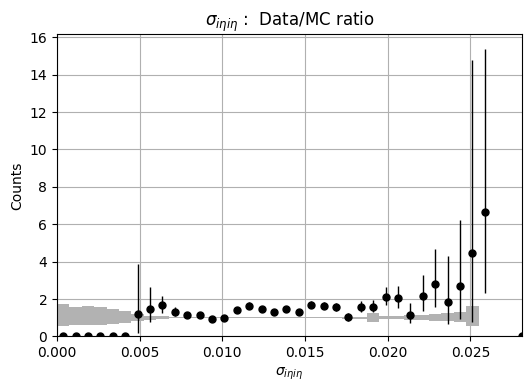

In [36]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_sieie_hist'],outputMC['photon_sieie_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('$\sigma_{i\eta i\eta}$ :  Data/MC ratio'); plt.grid()
plt.show()

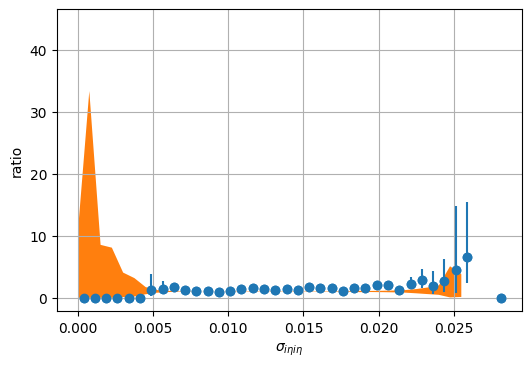

In [37]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_sieie_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_sieie_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_sieie_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_sieie_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_sieie_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_sieie_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('$\sigma_{i\eta i\eta}$'); plt.ylabel('ratio')
plt.show()

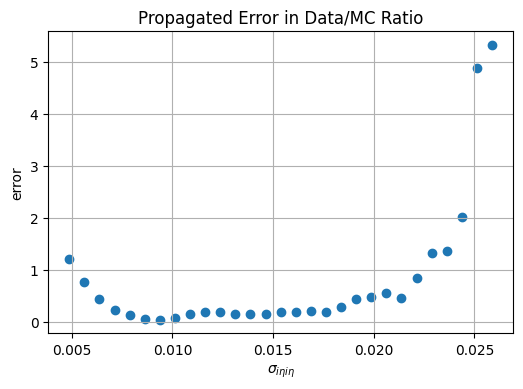

In [38]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('$\sigma_{i\eta i\eta}$'); plt.ylabel('error')
plt.show()

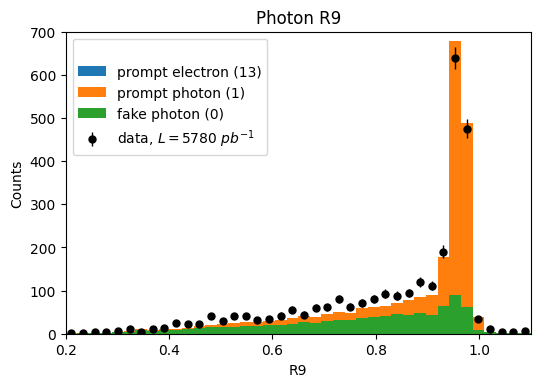

In [39]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_r9_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_r9_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,700); plt.title('Photon R9'); plt.show()

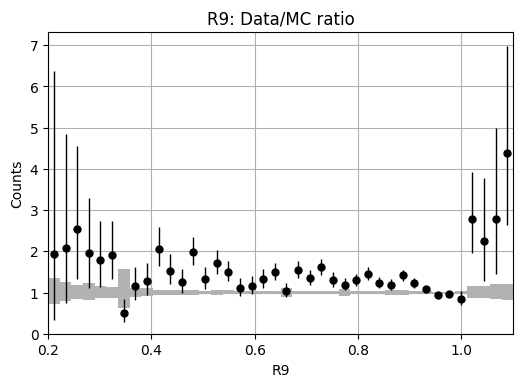

In [40]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_r9_hist'],outputMC['photon_r9_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('R9: Data/MC ratio'); plt.grid()
plt.show()

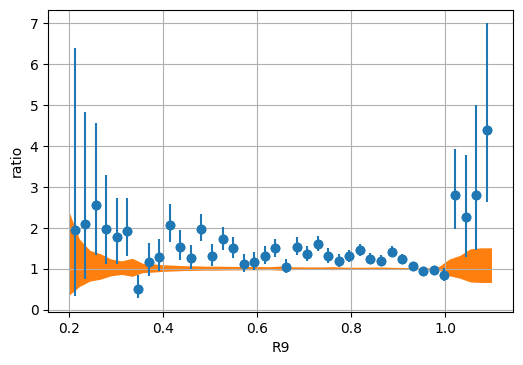

In [41]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_r9_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_r9_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_r9_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_r9_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_r9_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_r9_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('R9'); plt.ylabel('ratio')
plt.show()

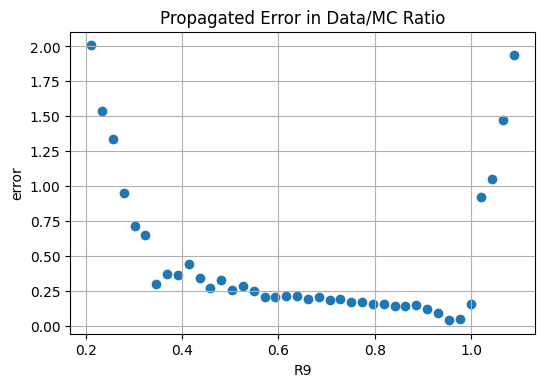

In [42]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('R9'); plt.ylabel('error')
plt.show()

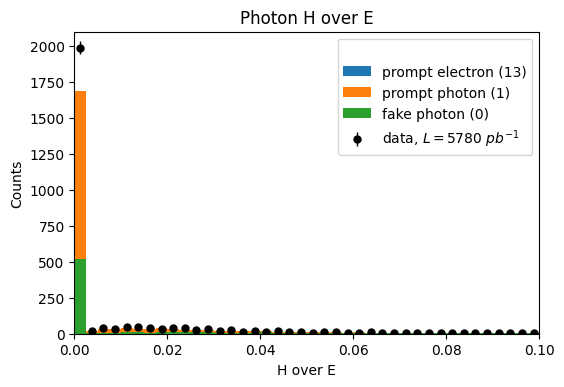

In [43]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_hoe_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_hoe_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,2100); plt.title('Photon H over E'); plt.show()

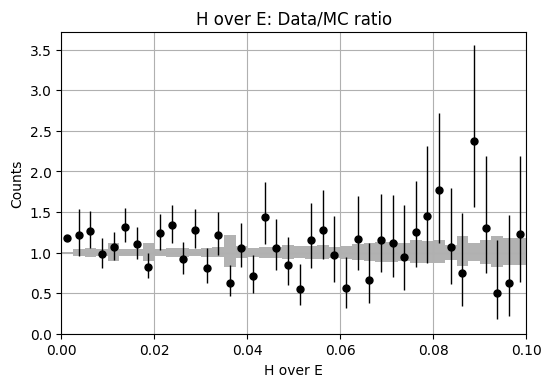

In [44]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['photon_hoe_hist'],outputMC['photon_hoe_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('H over E: Data/MC ratio'); plt.grid()
plt.show()

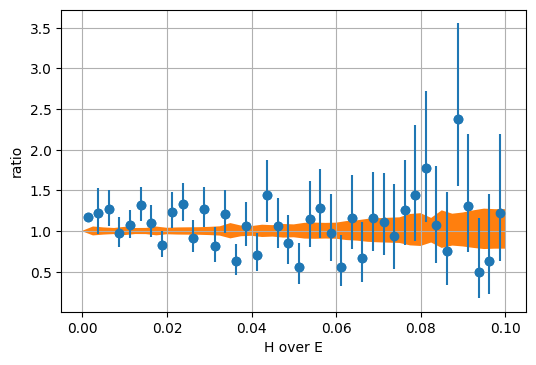

In [45]:
## ---- systematic uncertainties ---- ##
centers = outputMC['photon_hoe_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['photon_hoe_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['photon_hoe_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['photon_hoe_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['photon_hoe_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['photon_hoe_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('H over E'); plt.ylabel('ratio')
plt.show()

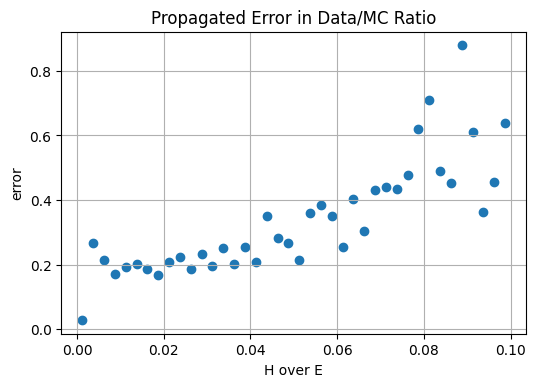

In [46]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('H over E'); plt.ylabel('error')
plt.show()

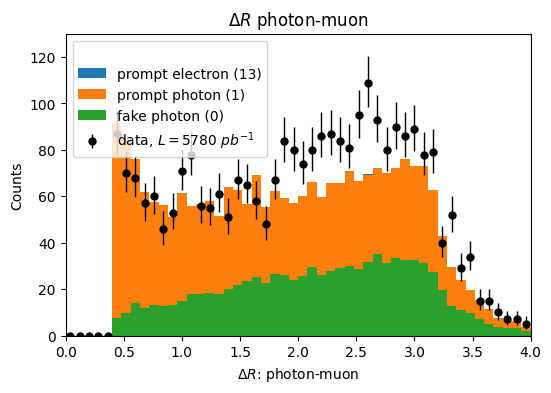

In [47]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_lepton_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['deltaR_photon_lepton_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,130); plt.title('$\Delta R$ photon-muon'); plt.show()

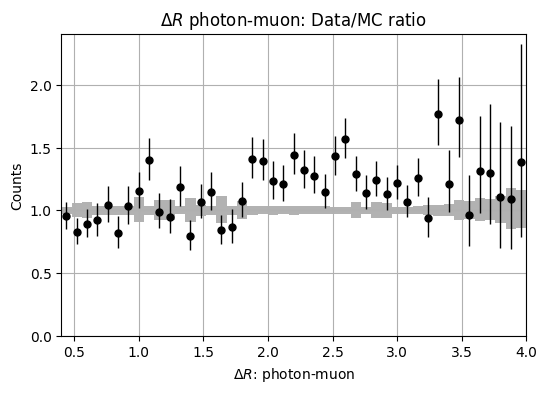

In [48]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['deltaR_photon_lepton_hist'],outputMC['deltaR_photon_lepton_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('$\Delta R$ photon-muon: Data/MC ratio'); plt.grid()
plt.show()

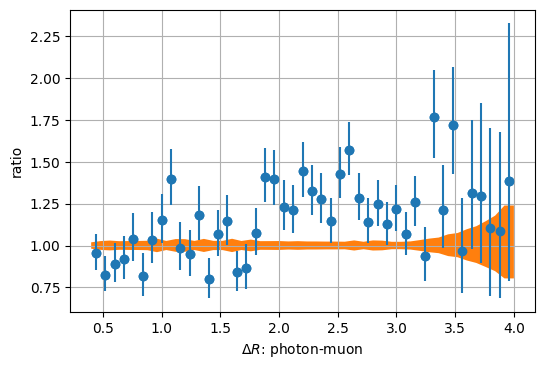

In [49]:
## ---- systematic uncertainties ---- ##
centers = outputMC['deltaR_photon_lepton_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['deltaR_photon_lepton_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['deltaR_photon_lepton_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['deltaR_photon_lepton_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['deltaR_photon_lepton_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['deltaR_photon_lepton_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('$\Delta R$: photon-muon'); plt.ylabel('ratio')
plt.show()

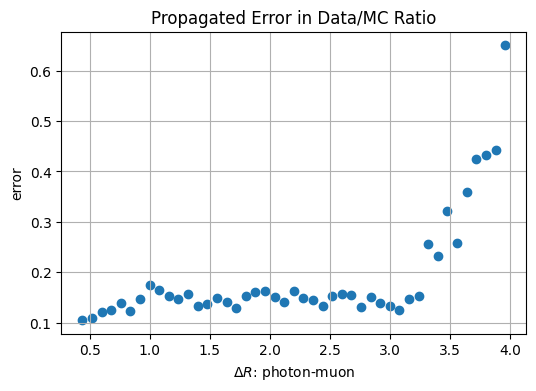

In [50]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('$\Delta R$: photon-muon'); plt.ylabel('error')
plt.show()

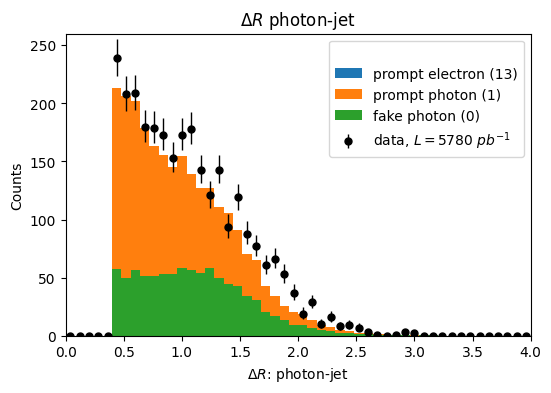

In [51]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_jet_hist'].sum('dataset'),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['deltaR_photon_jet_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,260); plt.title('$\Delta R$ photon-jet'); plt.show()

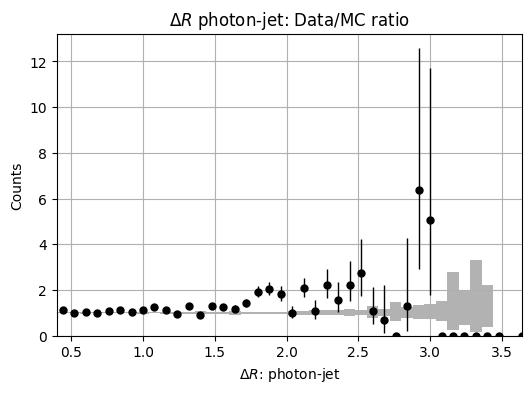

In [52]:
plt.figure(figsize=(6,4),dpi=100); ax1 = plt.subplot(1, 1, 1)
hist.plotratio(outputData['deltaR_photon_jet_hist'],outputMC['deltaR_photon_jet_hist'].sum('dataset').sum('flav'),unc='num',ax=ax1,error_opts=data_err_opts,denom_fill_opts=rat_denom_opts)
plt.title('$\Delta R$ photon-jet: Data/MC ratio'); plt.grid()
plt.show()

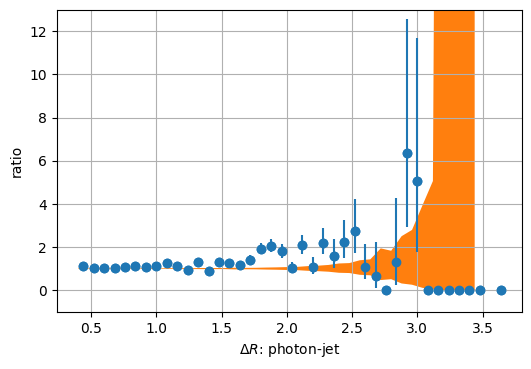

In [53]:
## ---- systematic uncertainties ---- ##
centers = outputMC['deltaR_photon_jet_hist'].sum("dataset").sum("flav").axes()[0].centers()
edges = outputMC['deltaR_photon_jet_hist'].sum("dataset").sum("flav").axes()[0].edges()

Dat, Dat_err2 = outputData['deltaR_photon_jet_hist'].values(sumw2=True)[()]
MC, MC_err2 = outputMC['deltaR_photon_jet_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
hi_MC, hi_MC_err2 = outputMC_high['deltaR_photon_jet_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]
lo_MC, lo_MC_err2 = outputMC_low['deltaR_photon_jet_hist'].sum("dataset").sum("flav").values(sumw2=True)[()]

rat = Dat/MC
hi_rat = Dat/hi_MC
lo_rat = Dat/lo_MC

unity = np.ones_like(MC)

rat_err = np.abs(poisson_interval(rat, Dat_err2 / MC**2) - rat)
tot_err = np.sqrt(MC_err2**2 + hi_MC_err2**2 + lo_MC_err2**2)

denom_unc = poisson_interval(unity, MC_err2 / MC**2)

sig = (hi_MC - lo_MC)/2
tot_err2 = np.sqrt(MC_err2 + (sig)**2)
tot_denom_unc = poisson_interval(unity, tot_err2 / MC**2)


plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, rat)
plt.errorbar(centers, rat, yerr=rat_err, fmt='o')
plt.fill_between(edges,
                 np.r_[tot_denom_unc[0], tot_denom_unc[0, -1]],
                 np.r_[tot_denom_unc[1], tot_denom_unc[1, -1]])
#plt.fill_between(edges,np.r_[denom_unc[0], denom_unc[0, -1]],np.r_[denom_unc[1],denom_unc[1, -1]],alpha=0.5)
plt.grid(); plt.xlabel('$\Delta R$: photon-jet'); plt.ylabel('ratio'); plt.ylim(-1,13)
plt.show()

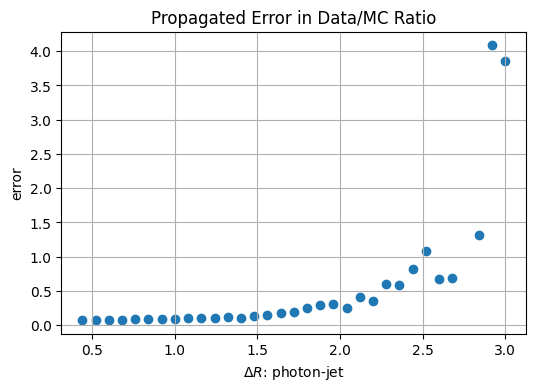

In [54]:
stat_err = abs(rat)*np.sqrt((Dat_err2/Dat**2) + (MC_err2/MC**2))

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(centers, stat_err)
plt.title('Propagated Error in Data/MC Ratio')
plt.grid(); plt.xlabel('$\Delta R$: photon-jet'); plt.ylabel('error')
plt.show()

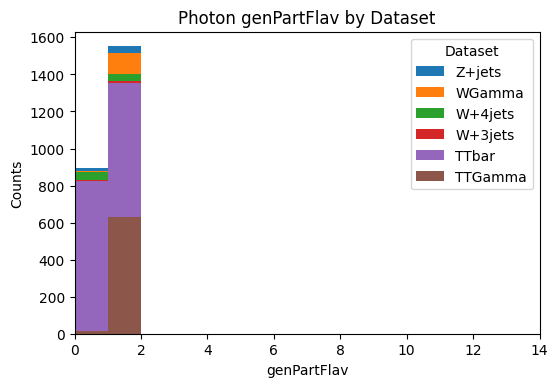

In [55]:
### label ###
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=True)
plt.title("Photon genPartFlav by Dataset")
plt.show()

## Preprocess data for training

In [56]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    # Removed from X_train before training:
    'photon_mvaID': np.array(outputMC['photon_mvaid'].value),
    'file': np.array(outputMC['file'].value),
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})

df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_mvaID,file,photon_genPartFlav
count,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000,199308.000000
mean,57.537060,0.006971,0.011501,0.011620,0.894946,0.009566,0.049870,0.014907,1.881212,0.985969,0.674680,0.828271,0.890431
std,56.189671,0.730159,1.813793,0.037462,0.152362,0.001806,0.222336,0.058664,0.925499,0.442571,0.563186,0.413908,0.347916
min,20.000051,-1.444092,-3.141602,0.000000,0.134155,0.000196,0.000000,0.000000,0.400002,0.400008,-0.999512,0.000000,0.000000
25%,25.090697,-0.569580,-1.556396,0.000000,0.885254,0.008865,0.000000,0.000000,1.040378,0.622247,0.731445,1.000000,1.000000
50%,38.344942,0.011635,0.006489,0.000000,0.953613,0.009209,0.003541,0.000000,1.909012,0.900718,0.935547,1.000000,1.000000
75%,65.709021,0.584015,1.584961,0.006393,0.965332,0.009598,0.029892,0.006597,2.672652,1.261720,0.979492,1.000000,1.000000
max,1116.671387,1.444092,3.141602,0.499023,14.968750,0.028076,18.950638,8.643118,4.776289,3.610590,0.998535,5.000000,13.000000


In [57]:
df['photon_genPartFlav'].value_counts()

1     177080
0      22198
13        30
Name: photon_genPartFlav, dtype: int64

In [58]:
# relabel 13 (=prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)
df['photon_genPartFlav'].value_counts()

1    177080
0     22228
Name: photon_genPartFlav, dtype: int64

In [59]:
### shuffle & split into train, val, test datasets ###

X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [60]:
### remove MVA ID and file features ###

test_mvaID = X_test['photon_mvaID']

X_train = X_train.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1)
X_test = X_test.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1)
X_val = X_val.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1)

In [61]:
### Scale: mean=0, stdev=1 ###

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## Build & train model

In [62]:
from keras.layers import Input
from keras.models import Model

In [63]:
'''
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()
'''

'\nmodel = Sequential()\nmodel.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))\nmodel.add(Dense(32, activation="relu"))\nmodel.add(Dense(1, activation="sigmoid"))\n\nmodel.compile("adam", "binary_crossentropy", metrics=["accuracy"])\nmodel.summary()\n'

In [64]:
# not a Sequential model:

xin = Input(shape=(X_train.shape[1],),name='input')
x = Dense(32, activation="relu")(xin)
x = Dense(32, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(xin,output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [65]:
callback = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100, batch_size=512, callbacks=[callback])


Epoch 1/100
234/234 [==============================] - 1s 5ms/step - loss: 0.2597 - accuracy: 0.9104 - val_loss: 0.1393 - val_accuracy: 0.9570
Epoch 2/100
234/234 [==============================] - 1s 4ms/step - loss: 0.1359 - accuracy: 0.9570 - val_loss: 0.1314 - val_accuracy: 0.9592
Epoch 3/100
234/234 [==============================] - 1s 4ms/step - loss: 0.1304 - accuracy: 0.9583 - val_loss: 0.1281 - val_accuracy: 0.9599
Epoch 4/100
234/234 [==============================] - 1s 4ms/step - loss: 0.1272 - accuracy: 0.9590 - val_loss: 0.1255 - val_accuracy: 0.9605
Epoch 5/100
234/234 [==============================] - 1s 4ms/step - loss: 0.1249 - accuracy: 0.9595 - val_loss: 0.1239 - val_accuracy: 0.9609
Epoch 6/100
234/234 [==============================] - 1s 4ms/step - loss: 0.1233 - accuracy: 0.9597 - val_loss: 0.1223 - val_accuracy: 0.9611
Epoch 7/100
234/234 [==============================] - 1s 4ms/step - loss: 0.1223 - accuracy: 0.9598 - val_loss: 0.1213 - val_accuracy: 0.9615

In [66]:
# save model:
path = !pwd
save_model(model, path[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /udrive/student/abraukman2020/PhotonClassification/assets


## Evaluate Model

In [67]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.12035
Test accuracy: 0.96076


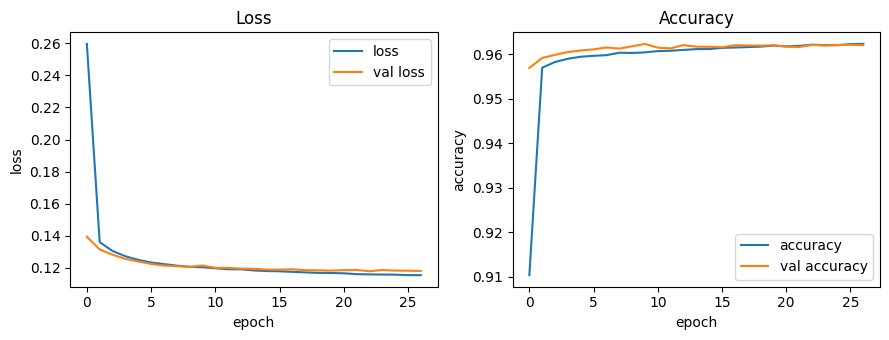

In [68]:
fig, axs = plt.subplots(1,2,figsize=(9,3.5),dpi=100)

axs[0].plot(history.history['loss'],label="loss")
axs[0].plot(history.history['val_loss'],label="val loss")
axs[1].plot(history.history['accuracy'],label="accuracy")
axs[1].plot(history.history['val_accuracy'],label="val accuracy")

axs[0].set_xlabel('epoch'); axs[0].set_ylabel('loss'); axs[0].set_title('Loss')
axs[1].set_xlabel('epoch'); axs[1].set_ylabel('accuracy'); axs[1].set_title('Accuracy')
axs[0].legend(); axs[1].legend()

plt.tight_layout()
plt.show()

### ROC Curve

In [69]:
y_pred = model.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

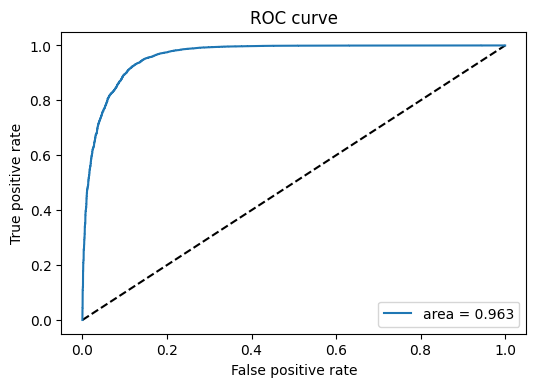

In [70]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Fill Prediction Histograms

This should happen in another Coffea Processor, but I'm having issues referencing `model` inside a processor

<AxesSubplot:xlabel='Prediction', ylabel='Counts'>

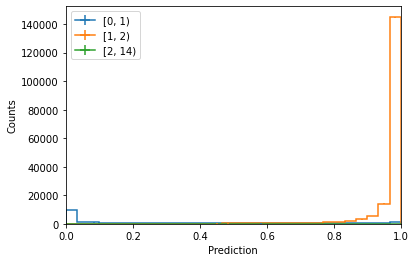

In [71]:
#####################################

# version without dataset axis
# (can't be scaled by luminosity)

#####################################

pred_axis = hist.Bin("pred", "Prediction", 30,0,1)
flavLabel_axis = hist.Bin("flav",None,[0,1,2,14])
# no dataset axis

## create histogram
unscaled_pred_hist = hist.Hist("Counts", pred_axis, flavLabel_axis)

## flavLabel axis
flavLabel = outputMC['photon_genPartFlav'].value

## prediction axis
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
})

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pred_for_hist = model.predict(df_scaled)
pred_for_hist = pred_for_hist.reshape(pred_for_hist.shape[0])

## fill histogram
unscaled_pred_hist.fill(flav=flavLabel,
                        pred=pred_for_hist)

hist.plot1d(unscaled_pred_hist,overlay='flav')

In [72]:
#####################################

# separate data by dataset before filling Hist
# can be scaled by luminosity

#####################################

In [73]:
## define axes
pred_axis = hist.Bin("pred", "Prediction", 30,0,1)
flavLabel_axis = hist.Bin("flav",None,[0,1,2,14])
dataset_axis = hist.Cat('dataset','Dataset')

## create histogram
outputMC['pred_hist'] = hist.Hist("Counts", dataset_axis, pred_axis, flavLabel_axis)

In [74]:
## prediction axis:

# dataframe for all datasets
df_for_prediction = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    'photon_mvaID': np.array(outputMC['photon_mvaid'].value),
    'file': np.array(outputMC['file'].value),
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})

# relabel dataset variables with strings
df_for_prediction.file[df_for_prediction.file == 0.0] = "TTGamma"
df_for_prediction.file[df_for_prediction.file == 1.0] = "TTbar"
df_for_prediction.file[df_for_prediction.file == 2.0] = "WGamma"
df_for_prediction.file[df_for_prediction.file == 3.0] = "Z+jets"
df_for_prediction.file[df_for_prediction.file == 4.0] = "W+3jets"
df_for_prediction.file[df_for_prediction.file == 5.0] = "W+4jets"

df_for_prediction.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_mvaID,file,photon_genPartFlav
0,20.062439,0.381165,2.965820,0.000000,0.663086,0.014297,0.000000,0.000000,2.276221,1.203371,-0.604004,W+3jets,0
1,21.895578,-1.262207,-2.060547,0.267578,0.520996,0.011757,0.195424,0.000000,3.549081,2.796165,-0.795410,W+3jets,0
2,33.680817,-0.641846,3.016113,0.000000,0.972656,0.010521,0.000000,0.000000,0.424546,0.424922,0.966309,W+3jets,1
3,71.110474,-0.476196,-0.442993,0.000000,0.952637,0.009109,0.000000,0.000000,2.516816,1.289921,0.983887,W+3jets,1
4,21.934734,0.895508,1.953369,0.227051,0.374512,0.013481,0.414233,0.264838,2.940416,1.491927,-0.992188,W+3jets,0


In [75]:
# separate dataframe by dataset
TTGamma_df = df_for_prediction[df_for_prediction.file == 'TTGamma']
TTbar_df = df_for_prediction[df_for_prediction.file == 'TTbar']
WGamma_df = df_for_prediction[df_for_prediction.file == 'WGamma']
Zjets_df = df_for_prediction[df_for_prediction.file == 'Z+jets']
W3jets_df = df_for_prediction[df_for_prediction.file == 'W+3jets']
W4jets_df = df_for_prediction[df_for_prediction.file == 'W+4jets']

In [76]:
# call model.predict() for each dataset

TTG_df = TTGamma_df.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1).drop(['photon_genPartFlav'],axis=1)
scaler = StandardScaler()
TTG_df_scaled = scaler.fit_transform(TTG_df)
TTG_pred = model.predict(TTG_df_scaled)
TTG_pred = TTG_pred.reshape(TTG_pred.shape[0])

TTb_df = TTbar_df.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1).drop(['photon_genPartFlav'],axis=1)
scaler = StandardScaler()
TTb_df_scaled = scaler.fit_transform(TTb_df)
TTb_pred = model.predict(TTb_df_scaled)
TTb_pred = TTb_pred.reshape(TTb_pred.shape[0])

WG_df = WGamma_df.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1).drop(['photon_genPartFlav'],axis=1)
scaler = StandardScaler()
WG_df_scaled = scaler.fit_transform(WG_df)
WG_pred = model.predict(WG_df_scaled)
WG_pred = WG_pred.reshape(WG_pred.shape[0])

Zj_df = Zjets_df.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1).drop(['photon_genPartFlav'],axis=1)
scaler = StandardScaler()
Zj_df_scaled = scaler.fit_transform(Zj_df)
Zj_pred = model.predict(Zj_df_scaled)
Zj_pred = Zj_pred.reshape(Zj_pred.shape[0])

W3j_df = W3jets_df.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1).drop(['photon_genPartFlav'],axis=1)
scaler = StandardScaler()
W3j_df_scaled = scaler.fit_transform(W3j_df)
W3j_pred = model.predict(W3j_df_scaled)
W3j_pred = W3j_pred.reshape(W3j_pred.shape[0])

W4j_df = W4jets_df.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1).drop(['photon_genPartFlav'],axis=1)
scaler = StandardScaler()
W4j_df_scaled = scaler.fit_transform(W4j_df)
W4j_pred = model.predict(W4j_df_scaled)
W4j_pred = W4j_pred.reshape(W4j_pred.shape[0])

In [77]:
## flavLabel axis
TTG_flavLabel = np.array(TTGamma_df.photon_genPartFlav)
TTb_flavLabel = np.array(TTbar_df.photon_genPartFlav)
WG_flavLabel = np.array(WGamma_df.photon_genPartFlav)
Zj_flavLabel = np.array(Zjets_df.photon_genPartFlav)
W3j_flavLabel = np.array(W3jets_df.photon_genPartFlav)
W4j_flavLabel = np.array(W4jets_df.photon_genPartFlav)

In [78]:
## fill histogram
outputMC['pred_hist'].fill(flav=TTG_flavLabel,
                           pred=TTG_pred,
                           dataset="TTGamma")

outputMC['pred_hist'].fill(flav=TTb_flavLabel,
                           pred=TTb_pred,
                           dataset="TTbar")

outputMC['pred_hist'].fill(flav=WG_flavLabel,
                           pred=WG_pred,
                           dataset="WGamma")

outputMC['pred_hist'].fill(flav=Zj_flavLabel,
                           pred=Zj_pred,
                           dataset="Z+jets")

outputMC['pred_hist'].fill(flav=W3j_flavLabel,
                           pred=W3j_pred,
                           dataset="W+3jets")

outputMC['pred_hist'].fill(flav=W4j_flavLabel,
                           pred=W4j_pred,
                           dataset="W+4jets")

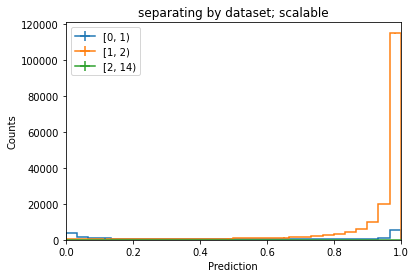

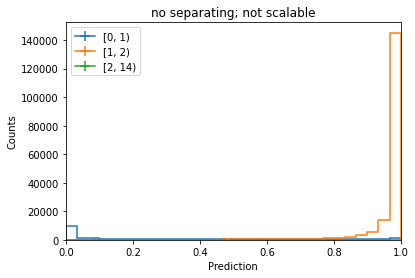

In [79]:
hist.plot1d(outputMC['pred_hist'].sum('dataset'),overlay='flav')
plt.title('separating by dataset; scalable')
plt.show()
# the shape is wrong---longer tail on 1.0 peak, too many false positive predictions
# compare to hist filled without .add() below:

hist.plot1d(unscaled_pred_hist,overlay='flav')
plt.title('no separating; not scalable')
plt.show()

lumi_weight:
{'TTGamma': 0.003943773852360702, 'TTbar': 0.043062066086220215, 'WGamma': 0.46305778826593263, 'Z+jets': 3.937800645987822, 'W+3jets': 0.34035491476285346, 'W+4jets': 0.37591232487961324}


<AxesSubplot:xlabel='Prediction', ylabel='Counts'>

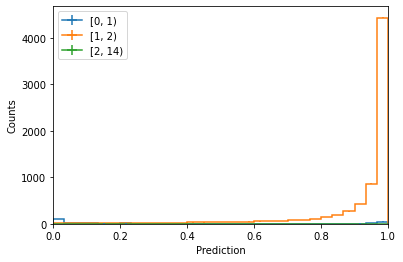

In [80]:
#### scale MC histogram ####

# weights (copied from LoadData.ipynb)
lumi_weight = {'TTGamma': 0.003943773852360702,
               'TTbar': 0.043062066086220215,
               'WGamma': 0.46305778826593263,
               'Z+jets': 3.937800645987822,
               'W+3jets': 0.34035491476285346,
               'W+4jets': 0.37591232487961324}
print('lumi_weight:'); print(lumi_weight)

outputMC['pred_hist'].scale(lumi_weight, axis="dataset")
hist.plot1d(outputMC['pred_hist'].sum('dataset'),overlay='flav')

In [81]:
## data histogram:

df_for_pred_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value)
})

df_for_pred_data.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
0,48.455196,-0.050720,1.281982,0.000000,0.964844,0.009499,0.029813,0.000000,1.029062,1.029966
1,20.564062,0.552490,-1.568604,0.000000,0.932617,0.011185,0.075195,0.075195,2.195301,1.799365
2,30.615404,-0.949219,0.172913,0.018677,0.956055,0.010429,0.000000,0.000000,1.219252,0.782207
3,68.909515,-0.230408,-2.479980,0.000000,0.823730,0.012505,0.266878,0.000000,1.418850,1.411853
4,33.592075,-0.092758,-0.440735,0.000000,0.646484,0.008667,0.012471,0.012471,0.738215,1.116607


<AxesSubplot:xlabel='Prediction', ylabel='Counts'>

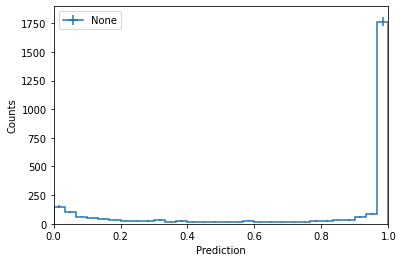

In [82]:
outputData['pred_hist'] = hist.Hist("Counts", pred_axis)

scaler = StandardScaler()
data_df_scaled = scaler.fit_transform(df_for_pred_data)
data_pred = model.predict(data_df_scaled)
data_pred = data_pred.reshape(data_pred.shape[0])

outputData['pred_hist'].fill(pred=data_pred)

hist.plot1d(outputData['pred_hist'])

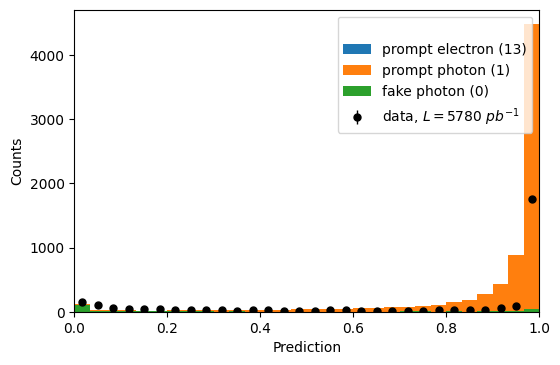

In [83]:
# plot scaled MC hist & data hist together
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['pred_hist'].sum('dataset'),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['pred_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.show()

### Correlation Matrix

In [84]:
X_test['prediction'] = y_pred
X_test.corr()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction
photon_pt,1.000000,-0.001673,-0.006762,-0.095873,0.116708,-0.101589,-0.087191,-0.099080,0.134360,0.193201,0.134704
photon_eta,-0.001673,1.000000,-0.008049,0.001791,0.011696,0.009103,0.004374,-0.000479,-0.007195,-0.001889,0.011501
photon_phi,-0.006762,-0.008049,1.000000,0.003170,-0.001019,0.004067,0.003544,-0.001925,0.000432,-0.000861,-0.003460
photon_hoe,-0.095873,0.001791,0.003170,1.000000,-0.124527,0.375704,0.202955,0.235547,0.036881,-0.000023,-0.414900
photon_r9,0.116708,0.011696,-0.001019,-0.124527,1.000000,-0.090895,0.185010,-0.066448,-0.017658,-0.004826,0.283721
photon_sieie,-0.101589,0.009103,0.004067,0.375704,-0.090895,1.000000,0.379977,0.297941,0.068103,0.044695,-0.801922
photon_pfRelIso03_all,-0.087191,0.004374,0.003544,0.202955,0.185010,0.379977,1.000000,0.447797,0.067173,-0.005323,-0.463817
photon_pfRelIso03_chg,-0.099080,-0.000479,-0.001925,0.235547,-0.066448,0.297941,0.447797,1.000000,0.062188,-0.045277,-0.406238
deltaR_photon_lepton,0.134360,-0.007195,0.000432,0.036881,-0.017658,0.068103,0.067173,0.062188,1.000000,0.321040,-0.142273
deltaR_photon_jet,0.193201,-0.001889,-0.000861,-0.000023,-0.004826,0.044695,-0.005323,-0.045277,0.321040,1.000000,-0.105988


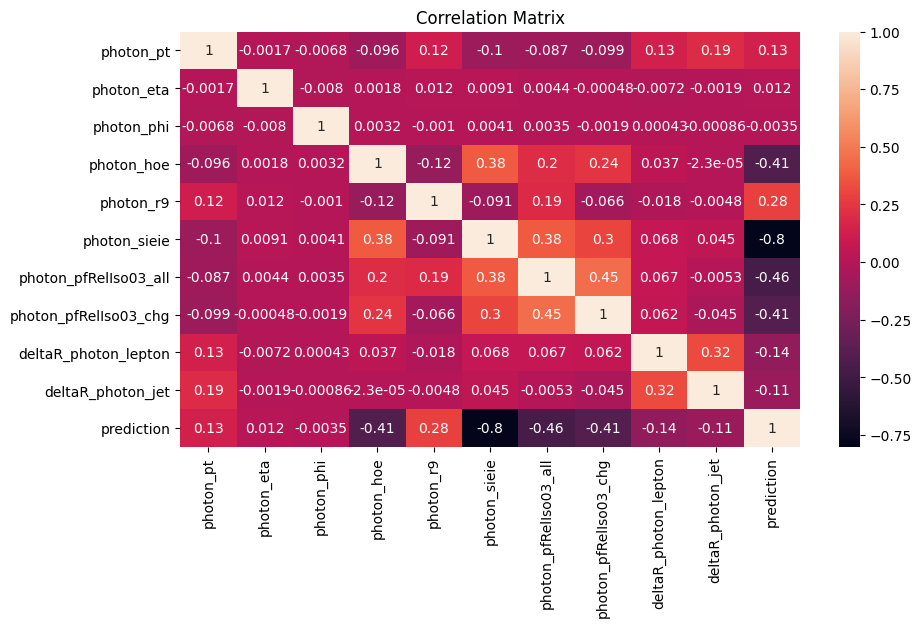

In [85]:
plt.figure(figsize=(10,5.5),dpi=100)
sns.heatmap(X_test.corr(method='pearson'),annot=True)
plt.title('Correlation Matrix')
plt.show()

### Run Model on Data

In [86]:
X_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})

X_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000
mean,50.570141,-0.015870,0.039076,0.019639,0.850088,0.011005,0.177118,0.034467,2.034481,1.057087
std,48.258934,0.754341,1.814194,0.056136,0.263620,0.003260,0.442766,0.088914,0.898282,0.476950
min,20.008158,-1.443848,-3.141602,0.000000,0.205566,0.005196,0.000000,0.000000,0.400251,0.400223
25%,23.618339,-0.625336,-1.500305,0.000000,0.744995,0.008942,0.000000,0.000000,1.280361,0.652916
50%,33.360886,-0.023134,0.002344,0.000000,0.917969,0.009453,0.031615,0.000000,2.123417,0.989416
75%,56.436961,0.590912,1.599121,0.010757,0.961914,0.012686,0.166739,0.031940,2.758509,1.361372
max,513.060974,1.443604,3.141113,0.492188,5.441406,0.026840,6.650416,1.445951,4.548167,3.018653


In [87]:
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

In [88]:
y_pred_data = model.predict(X_data_scaled)

In [89]:
# fill the `prediction_hist` in `outputData`
# plot MC & Data prediction histograms together



### Compare to MVA ID

In [90]:
predTrue  = y_pred[y_test==1]
predFalse = y_pred[y_test==0]

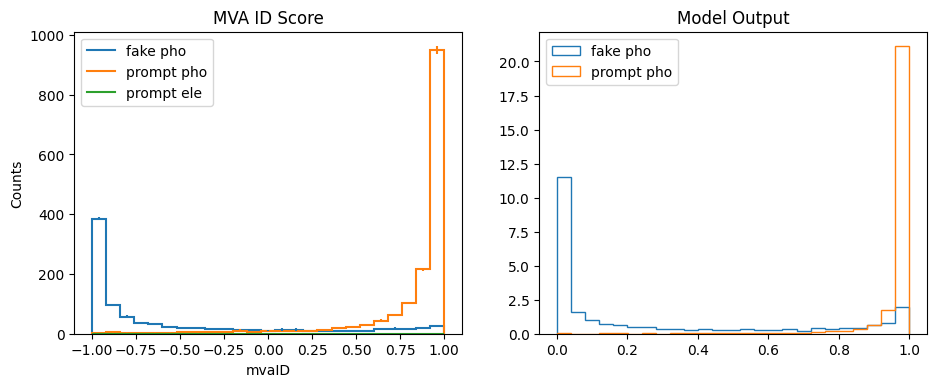

In [91]:
fig, axs = plt.subplots(1,2,figsize=(11,4),dpi=100)

MC_legend_opts = {'loc':'upper left', 'labels': ['fake pho','prompt pho','prompt ele']}
hist.plot1d(outputMC['photon_mvaid_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[0],legend_opts=MC_legend_opts)
axs[0].set_xlim(-1.1,1.1)

axs[1].hist(predFalse,bins=25,density=True,label='fake pho',histtype='step')
axs[1].hist(predTrue,bins=25,density=True,label='prompt pho',histtype='step')
axs[1].legend(loc="upper left")

axs[0].set_title('MVA ID Score')
axs[1].set_title('Model Output')
plt.show()

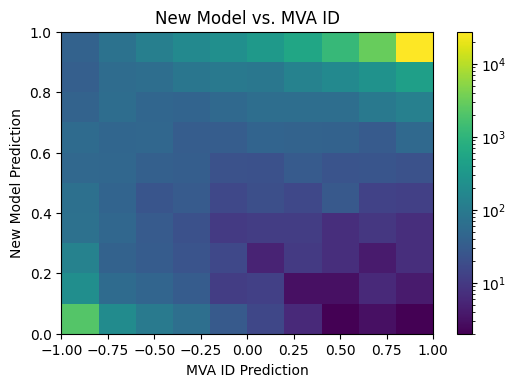

In [92]:
## 2D histograms: new model vs. MVA ID ##
plt.figure(figsize=(6,4),dpi=100)

plt.hist2d(test_mvaID, y_pred.reshape(y_pred.shape[0]),norm=colors.LogNorm())

plt.xlabel('MVA ID Prediction'); plt.xlim(-1,1)
plt.ylabel('New Model Prediction'); plt.ylim(0,1)
plt.title('New Model vs. MVA ID')
plt.colorbar()
plt.show()


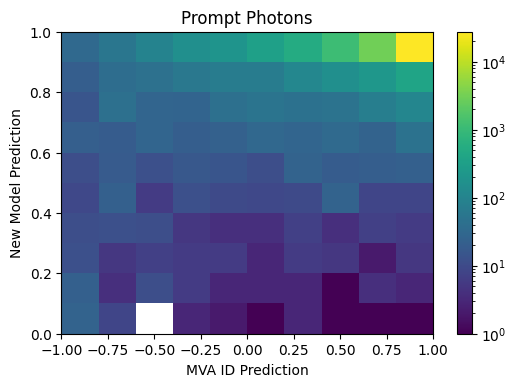

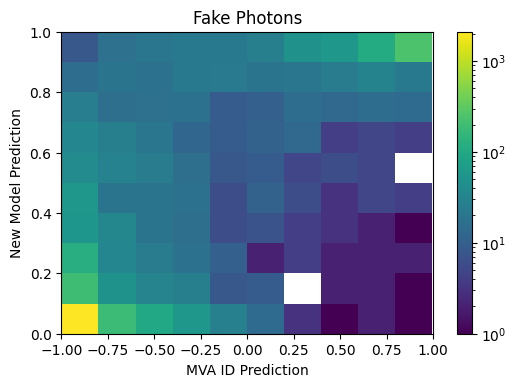

In [93]:
# separate above plot into fake photons and prompt photons

mvaTrue = test_mvaID[y_test==1]
mvaFalse = test_mvaID[y_test==0]

plt.figure(figsize=(6,4),dpi=100)
plt.hist2d(mvaTrue,predTrue.reshape(predTrue.shape[0]),norm=colors.LogNorm())
plt.xlabel('MVA ID Prediction'); plt.ylabel('New Model Prediction')
plt.xlim(-1,1); plt.ylim(0,1)
plt.title('Prompt Photons')
plt.colorbar()
plt.show()

plt.figure(figsize=(6,4),dpi=100)
plt.hist2d(mvaFalse,predFalse.reshape(predFalse.shape[0]),norm=colors.LogNorm())
plt.xlabel('MVA ID Prediction'); plt.ylabel('New Model Prediction')
plt.xlim(-1,1); plt.ylim(0,1)
plt.title('Fake Photons')
plt.colorbar()
plt.show()


In [94]:
### analyze events where model output = 1, MVA ID = -1 ###
X_test['mvaID'] = test_mvaID

mod1_mva0_prompt = X_test[(X_test['prediction']>0.5) & (X_test['mvaID']<0) & (y_test==1)]
mod1_mva0_fake = X_test[(X_test['prediction']>0.5) & (X_test['mvaID']<0) & (y_test==0)]

mod1_mva0_prompt.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,mvaID
59382,102.508591,-0.524048,-1.349609,0.000000,0.968750,0.009689,0.041082,0.041082,2.863927,1.078394,0.900020,-0.088623
144144,160.594910,-0.255493,-2.213867,0.021545,0.969238,0.008965,0.081321,0.048055,2.593385,0.915328,0.830347,-0.369141
183345,35.964760,1.369873,-1.991699,0.014709,0.966309,0.009346,0.494581,0.388778,2.842268,0.479471,0.845301,-0.104919
35675,44.955734,0.782959,2.095215,0.017700,0.940918,0.009995,0.062251,0.000000,2.194499,0.580851,0.932572,-0.147705
64840,21.188910,-0.338074,-0.501343,0.000000,0.432129,0.007698,0.270436,0.270436,2.301841,0.640318,0.779737,-0.657715


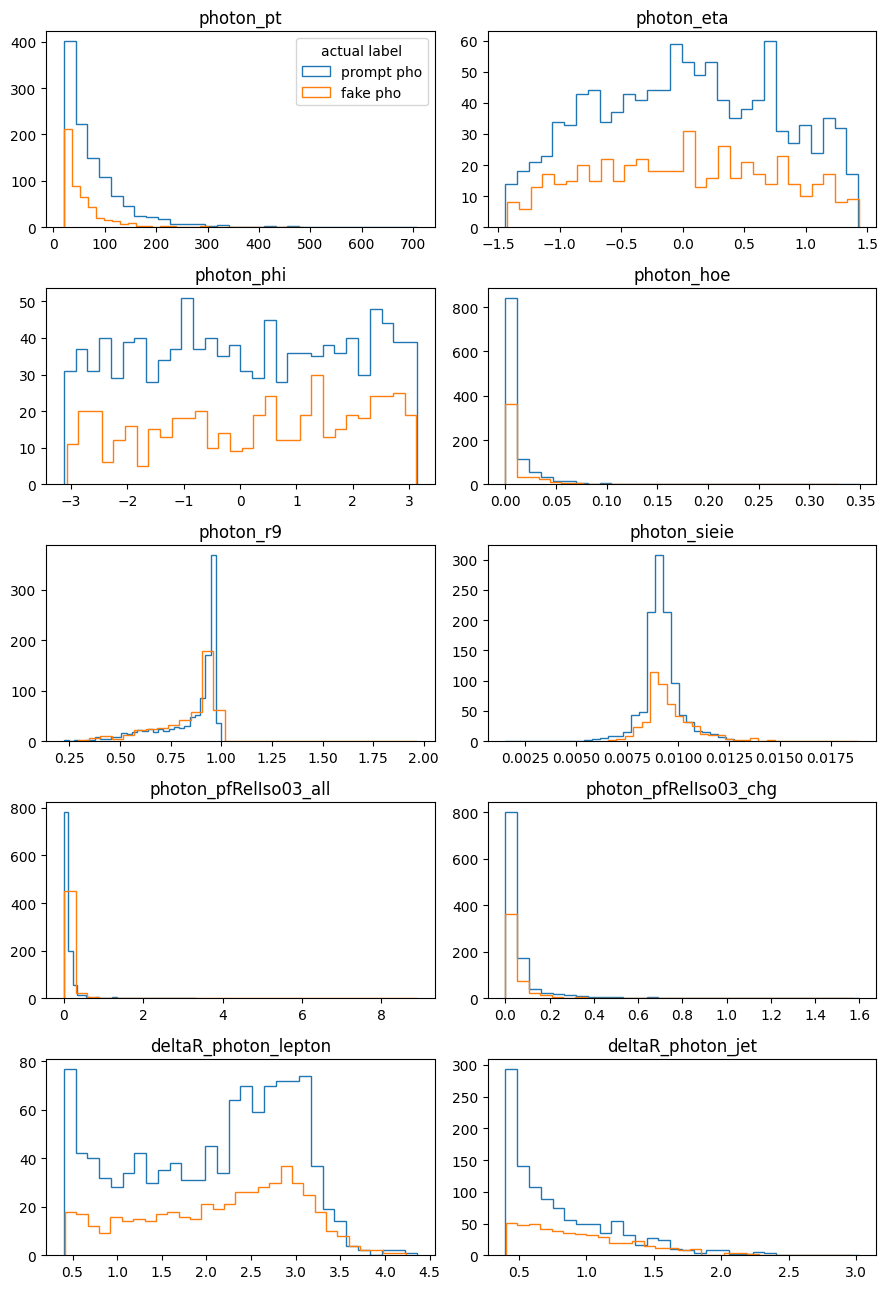

In [95]:
# compare features:
fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(mod1_mva0_prompt[mod1_mva0_prompt.keys()[feat]],bins=30,histtype="step",label="prompt pho")
        axs[row,col].hist(mod1_mva0_fake[mod1_mva0_prompt.keys()[feat]],bins=30,histtype="step",label="fake pho")
        axs[row,col].set_title(mod1_mva0_prompt.keys()[feat])
        feat = feat+1

axs[0,0].legend(loc="best",title="actual label")
fig.tight_layout()
plt.show()

In [96]:
## ROC curve for MVA ID ##

fprMVA, tprMVA, threshMVA = roc_curve(y_test,test_mvaID)
aucMVA = auc(fprMVA,tprMVA)

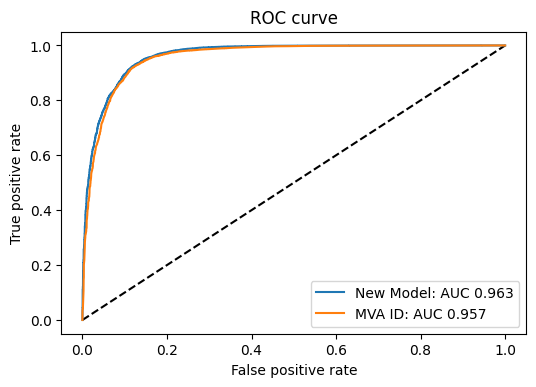

In [97]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='New Model: AUC {:.3f}'.format(area_under_curve))
plt.plot(fprMVA, tprMVA, label='MVA ID: AUC {:.3f}'.format(aucMVA))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Analyze Incorrectly-Classified Fake Photons

In [98]:
X_test['target'] = y_test
X_test.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,mvaID,target
141622,64.012627,0.542358,-1.669678,0.000000,0.966797,0.009315,0.009621,0.009621,0.477044,0.480946,0.999634,0.982422,1
30773,38.731339,-0.668335,0.573242,0.000000,0.863281,0.010239,0.106062,0.029688,2.381813,1.698142,0.130786,-0.835938,0
182831,61.586884,-1.420166,1.145508,0.006653,0.377197,0.008934,0.098430,0.086871,2.323130,0.913690,0.112586,-0.963379,0
141559,70.632965,0.010611,1.250977,0.014801,0.964355,0.009171,0.005876,0.000000,1.245953,0.760194,0.999139,0.982422,1
28761,20.375998,-0.814575,-0.528564,0.000000,0.709961,0.011757,0.318505,0.000000,1.380137,1.373199,0.026197,-0.854004,0


In [99]:
# incorrectly-classified fake photons:
# target = 0, prediction > 0.5

falseNeg = X_test[(X_test['target'] == 1) & (X_test['prediction'] < 0.5)]
truePos  = X_test[(X_test['target'] == 1) & (X_test['prediction'] > 0.5)]
trueNeg  = X_test[(X_test['target'] == 0) & (X_test['prediction'] < 0.5)]
falsePos = X_test[(X_test['target'] == 0) & (X_test['prediction'] > 0.5)]

In [100]:
# confusion matrix
con_mat = np.array([len(trueNeg),len(falsePos),len(falseNeg),len(truePos)])
con_mat_names = np.array(['True Neg:','False Pos:','False Neg:','True Pos:'])
con_mat_perc = ((con_mat/np.sum(con_mat))*100).round(2)

con_mat.reshape(2,2)

array([[ 3334,  1212],
       [  352, 34964]])

In [101]:
labels = [f"{v1}\n{v2}\n({v3}%)" for v1,v2,v3 in zip(con_mat_names,con_mat,con_mat_perc)]
labels = np.asarray(labels).reshape(2,2)

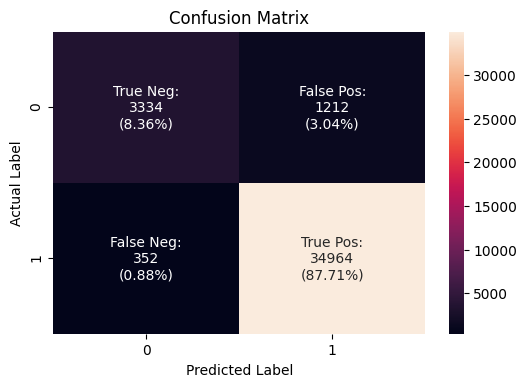

In [102]:
plt.figure(figsize=(6,4),dpi=100)
sns.heatmap(con_mat.reshape(2,2),annot=labels,fmt='')
plt.xlabel('Predicted Label'); plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

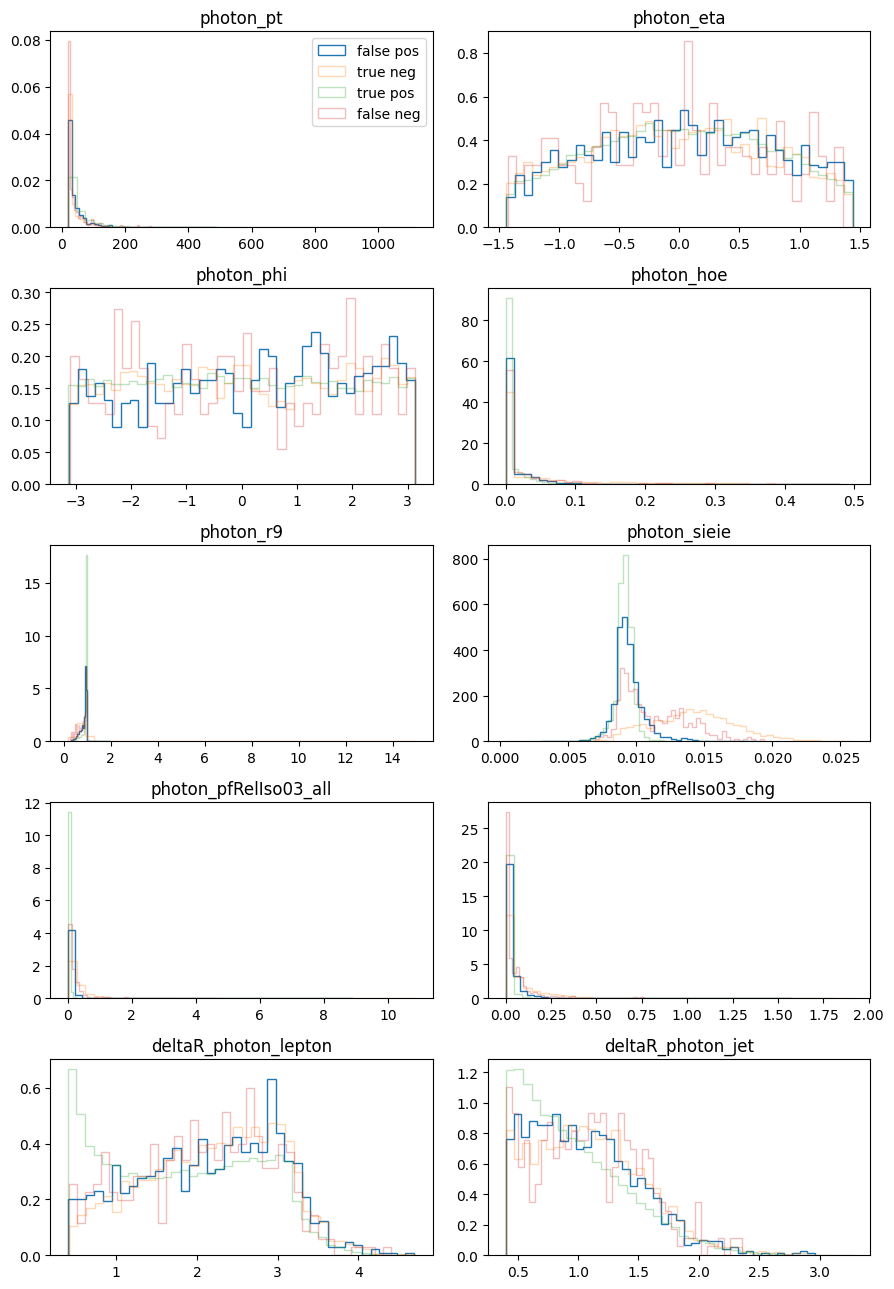

In [103]:
### compare features ###

fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(falsePos[falsePos.keys()[feat]],bins=40,histtype="step",density=True,label="false pos")
        axs[row,col].hist(trueNeg[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.3,density=True,label="true neg")
        axs[row,col].hist(truePos[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.3,density=True,label="true pos")
        axs[row,col].hist(falseNeg[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.3,density=True,label="false neg")
        
        axs[0,0].legend(loc="best")
        axs[row,col].set_title(falsePos.keys()[feat])
        feat = feat+1

fig.tight_layout()
plt.show()

### Plot ROC curve manually

In [104]:
FPR = []
TPR = []

thresholds = np.linspace(0,1,num=201)

# number of positive (P) and negative (N) samples
P = X_test.target.sum()
N = len(X_test.target) - P

# determine number of true pos & false pos samples for each threshold
for thresh in thresholds:
    FP = 0
    TP = 0
    
    pos = X_test[X_test.prediction>=thresh]
    
    TP = pos.target.sum()
    FP = len(pos.target) - TP
    
    FPR.append(FP/N)
    TPR.append(TP/P)

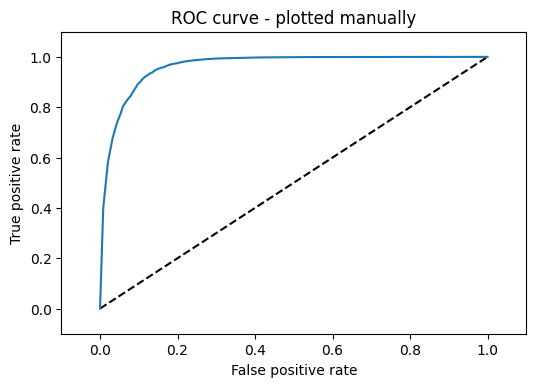

In [105]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(FPR, TPR)

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - plotted manually')
plt.show()

## try: post-training processor in the same notebook as the model training

In [106]:
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [107]:
class PhotonPredictor(processor.ProcessorABC):
    def __init__(self):
        
        self.model = model

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")
        flavLabel_axis = hist.Bin("flav",None,[0,1,2])
        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",14,0,14)
        prediction_axis = hist.Bin("pred","Prediction",30,0,1)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            'prediction': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
            'prediction_hist': hist.Hist("Counts", dataset_axis, flavLabel_axis, prediction_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    
    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4 # tight cut-based ID
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # delta R cuts
        phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
        phoMuMask = ak.fill_none(phoMuDR>0.4,True)
        
        phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
        phoJetMask = ak.fill_none(phoJetDR>0.4,True)
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed) &
                       phoMuMask & phoJetMask
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        ######## fill histograms ########
        flavLabel = ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav))
        flavLabel[flavLabel == 13] = 0 # relabel prompt electrons as fake photons
        
        X = pd.DataFrame({
            'photon_pt': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)),
            'photon_eta': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)),
            'photon_phi': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)),
            'photon_hoe': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)),
            'photon_r9': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)),
            'photon_sieie': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)),
            'photon_pfRelIso03_all': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)),
            'photon_pfRelIso03_chg': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)),
            'deltaR_photon_lepton': ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])),
            'deltaR_photon_jet': ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])),
        })
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        #print(ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)).shape, X.shape)
        
        #y = model.predict(X_scaled)
        
        #output['photon_genPartFlav_hist'].fill(dataset=dataset,
        #                                       flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        #output['prediction_hist'].fill(dataset=dataset, flav=flavLabel,
        #                               pred=y.reshape(y.shape[0],))
        
        ######## fill column accumulators ########
        #output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
        #output['prediction'] = processor.column_accumulator(y.reshape(y.shape[0],))
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [108]:
# Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"]
          }
filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"]
              }

In [109]:
np.warnings.filterwarnings('ignore')

# The NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [110]:
# Run Coffea code using uproot

outputMC_PostTraining = processor.run_uproot_job(
    fileset,
    "Events",
    PhotonPredictor(),
    processor.iterative_executor,
    executor_args={"schema": SkimmedSchema},
    chunksize=100000,
    maxchunks=3,
)

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

TypeError: '<' not supported between instances of 'InputLayer' and 'Functional'